In [26]:
import torch
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm

from time import time

# plotting utilities
import revert.plot as rp

# infusion data loaders
from revert import infusion

### Read ICP recording and timestamps

In [27]:
from revert.transforms import filter_spikes, bandpass, Troughs

In [32]:
db = infusion.Dataset("full")
fs = 100
file = db.get(1)

# read full icp recording
t0 = time()
icp_raw = file.icp()
t1 = time()
print(f'reading hdf5 data stream:\t{t1 - t0:.3f} s')

reading hdf5 data stream:	3.040 s


#### Compare HDF5 with .pt 

In [33]:
torch.save(icp_raw, "icp_raw.pt")
t0 = time()
icp_raw = torch.load("icp_raw.pt")
t1 = time()
print(f'reading hdf5 data stream:\t{t1 - t0:.3f} s')

reading hdf5 data stream:	0.001 s


#### Clean the raw signal

In [34]:
# interpolate on missing data points
icp_full, mask = filter_spikes(icp_raw)

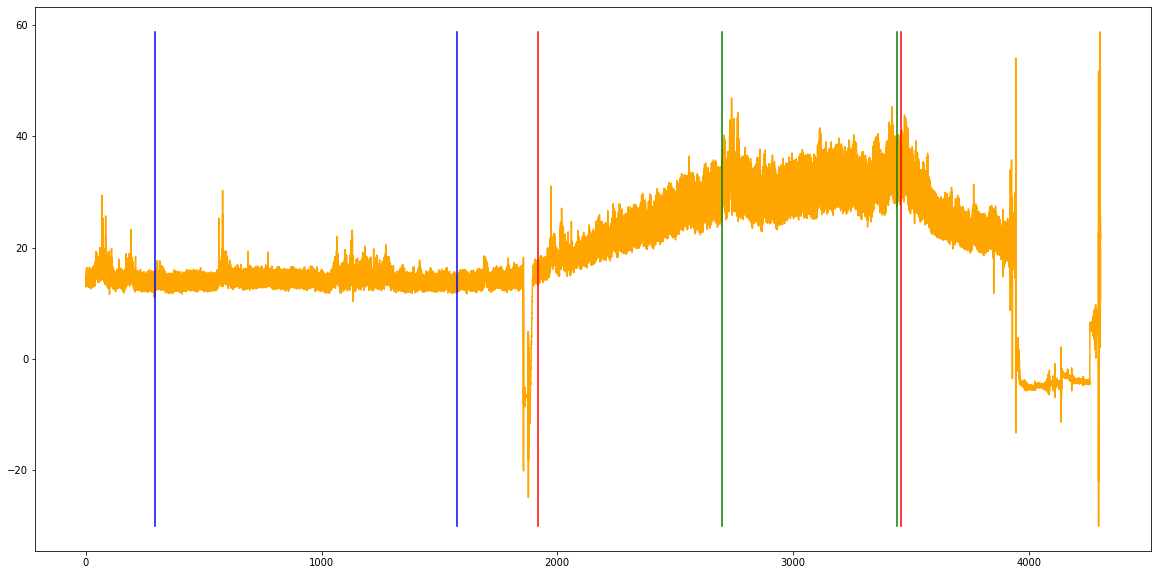

In [35]:
# read timestamps from $INFUSION_DATASETS/periods-full.json
periods = db.periods[file.key]

# plot with timestamps
rp.infusion(icp_full, periods)
plt.show()

### Segment baseline signal

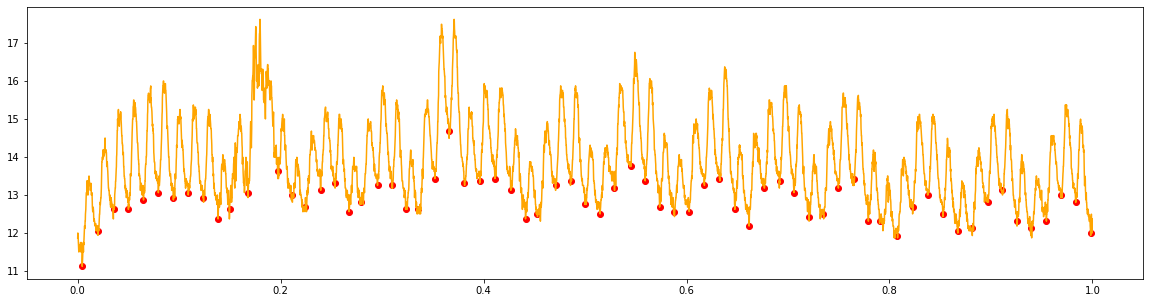

In [36]:
# Baseline first minutes
i0, i1 = periods["Baseline"]
N = 1 * 6000
time = torch.arange(N) / (fs * 60)
icp  = icp_full[int(100 * i0):int(100 * i0) + N]

# Find diastoles
argmin  = Troughs(N, 50)
bp      = bandpass(0.6, 12, fs)
troughs = argmin(bp(icp))

# Plot 
plt.figure(figsize=(20, 5))
plt.plot(time, icp, color='orange')
plt.scatter(time[troughs], icp[troughs], color='red')
plt.show()

### Model image of the segments


In [8]:
from models   import ConvNet
from infusion import segment, mask_center, diff

# model trained on synthetic augmentations only
# (noise, scalings, dc shifts) - see revert/experiments/twins.py
model = ConvNet.load("pretrained.pt")

# centered segments
pulses, mask = segment(bp(icp), troughs, 128, before=0)
x, x_mean, x_slope = mask_center(pulses, mask, output='slopes')

# model output and variations
with torch.no_grad():
    y  = model(x).detach()
    dy = diff(y.T).T
    y_m = y - y.mean([0])[None,:]

# energy
q1, q2 = y_m.norm(dim=[1]), dy.norm(dim=[1])
q = q1 + q2

# temperature
T = 3

# Gibbs density (~ softmin)
p = torch.exp(- q / T)
p /= p.sum()

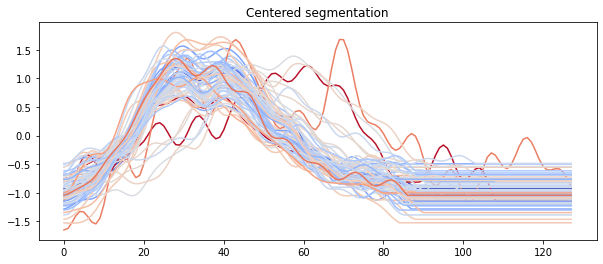

In [9]:
p_norm = (p - p.min()) / (p.max() - p.min())
color=cm.coolwarm_r(p_norm)

plt.figure(figsize=(10, 4))
for xi, ci in zip(x, color):
    plt.plot(xi, color=ci)
plt.title("Centered segmentation")
plt.show()

### Filtering pulses

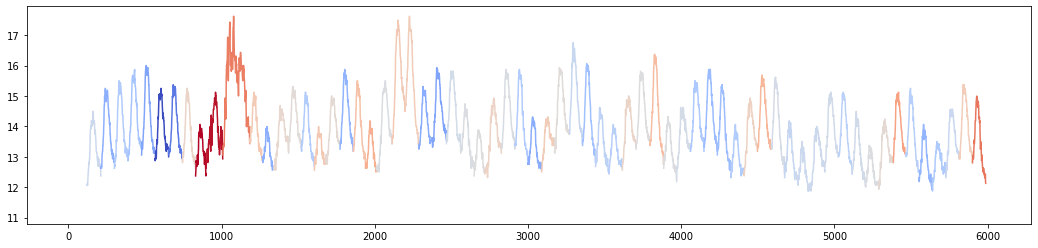

In [10]:
plt.figure(figsize=(18, 4))
for i, j, cij in zip(troughs[:-1], troughs[1:], color):
    ij = i + torch.arange(j - i)
    pij = icp[i:j]
    plt.plot(ij, pij, color=cij)